In [ ]:
#!pip install geoplot

In [ ]:
#!pip install contextily

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import geopandas as gpd
#import contextily as cx
from shapely.geometry import Point
#import geoplot.crs as gcrs
#import geoplot as gplt
import pyproj

In [2]:
from google.colab import auth
auth.authenticate_user()


In [3]:
# Reading csv file with geometry was taking a lot of time, so I saved separately trips data without geometry, which I will open now
data_path = 'gs://dataprep-staging-a351fd7d-4575-4a19-86f3-a0e85c39fc88/nataliia.shcheglovaa@gmail.com/jobrun/Capstone_3_data/trips_no_geom.csv'
data = pd.read_csv(data_path, storage_options={'token': 'cloud'}, encoding='latin-1', engine='c')

In [ ]:
data.head()

,request_date,request_hour,hvfhs_license_num,PULocationID,passenger_count,avg_passenger_wait_time,avg_congestion_surcharge,temp,dew,humidity,...,cloudcover,rain,snow,request_month,request_day,request_day_of_week,morning_time_request,night_time_request,day_time_request,evening_time_request
0,2021-01-01,0,HV0003,3,68,6.790931,0.080882,2.5,-3.0,67.8,...,50.6,1,0,1,1,4,0,1,0,0
1,2021-01-01,0,HV0003,4,100,4.221833,2.722500,2.5,-3.0,67.8,...,50.6,1,0,1,1,4,0,1,0,0
2,2021-01-01,0,HV0003,5,14,10.142857,0.000000,2.5,-3.0,67.8,...,50.6,1,0,1,1,4,0,1,0,0
3,2021-01-01,0,HV0003,6,18,7.538889,0.152778,2.5,-3.0,67.8,...,50.6,1,0,1,1,4,0,1,0,0
4,2021-01-01,0,HV0003,7,195,3.579316,0.394872,2.5,-3.0,67.8,...,50.6,1,0,1,1,4,0,1,0,0


In [ ]:
# Adding taxi zones geometry
zones_path = 'gs://dataprep-staging-a351fd7d-4575-4a19-86f3-a0e85c39fc88/nataliia.shcheglovaa@gmail.com/jobrun/Capstone_3_data/taxi_zones.shp'
taxi_zones = gpd.read_file(zones_path, storage_options={'token': 'cloud'})
zones_path2 = 'gs://dataprep-staging-a351fd7d-4575-4a19-86f3-a0e85c39fc88/nataliia.shcheglovaa@gmail.com/jobrun/Capstone_3_data/taxi_zone_lookup.csv'
taxi_zones2 = pd.read_csv(zones_path2, storage_options={'token': 'cloud'})
taxi_zones = taxi_zones2.merge(taxi_zones,left_index=True,right_index=True,how='left')
taxi_zones.head()

/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option STORAGE_OPTIONS
  return ogr_read(


,LocationID,Borough,Zone,service_zone,geometry
0,1,EWR,Newark Airport,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,Queens,Jamaica Bay,Boro Zone,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,Manhattan,Alphabet City,Yellow Zone,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,Staten Island,Arden Heights,Boro Zone,"POLYGON ((935843.31 144283.336, 936046.565 144..."


In [ ]:
# Adding geometric attributes: area, boundaries, and centroids
taxi_zones = gpd.GeoDataFrame(taxi_zones, geometry='geometry')

# Setting coordinate system to New york (espg: 2263)
taxi_zones.set_crs(epsg=2263, inplace=True)
taxi_zones['area'] = taxi_zones.area
taxi_zones['boundary'] = taxi_zones.boundary
taxi_zones['centroid'] = taxi_zones.centroid

In [ ]:
taxi_zones.head()

,LocationID,Borough,Zone,service_zone,geometry,area,boundary,centroid
0,1,EWR,Newark Airport,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",7.903953e+07,"LINESTRING (933100.918 192536.086, 933091.011 ...",POINT (935996.821 191376.75)
1,2,Queens,Jamaica Bay,Boro Zone,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",1.439095e+08,"MULTILINESTRING ((1033269.244 172126.008, 1033...",POINT (1031085.719 164018.754)
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone,"POLYGON ((1026308.77 256767.698, 1026495.593 2...",3.168508e+07,"LINESTRING (1026308.77 256767.698, 1026495.593...",POINT (1026452.617 254265.479)
3,4,Manhattan,Alphabet City,Yellow Zone,"POLYGON ((992073.467 203714.076, 992068.667 20...",8.023733e+06,"LINESTRING (992073.467 203714.076, 992068.667 ...",POINT (990633.981 202959.782)
4,5,Staten Island,Arden Heights,Boro Zone,"POLYGON ((935843.31 144283.336, 936046.565 144...",5.041488e+07,"LINESTRING (935843.31 144283.336, 936046.565 1...",POINT (931871.37 140681.351)


In [ ]:
demand = data.groupby('PULocationID').agg({'passenger_count':'sum'}).reset_index()
demand = demand.merge(taxi_zones[['LocationID','geometry','Zone']],left_on='PULocationID',right_on='LocationID',how='left')
demand.head()

,PULocationID,passenger_count,LocationID,geometry,Zone
0,1,12,1,"POLYGON ((933100.918 192536.086, 933091.011 19...",Newark Airport
1,2,352,2,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",Jamaica Bay
2,3,310766,3,"POLYGON ((1026308.77 256767.698, 1026495.593 2...",Allerton/Pelham Gardens
3,4,418743,4,"POLYGON ((992073.467 203714.076, 992068.667 20...",Alphabet City
4,5,35168,5,"POLYGON ((935843.31 144283.336, 936046.565 144...",Arden Heights


In [ ]:
demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PULocationID     263 non-null    int64   
 1   passenger_count  263 non-null    int64   
 2   LocationID       263 non-null    int64   
 3   geometry         261 non-null    geometry
 4   Zone             262 non-null    object  
dtypes: geometry(1), int64(3), object(1)
memory usage: 10.4+ KB


In [ ]:
demand.dropna(inplace=True)

# Univariate Analysis
### Numerical Features:
Checking distributions passenger_count, avg_passenger_wait_time, avg_congestion_surcharge, temp, precip to identify skewness, outliers, and data ranges.

In [ ]:
data.describe()

,request_hour,PULocationID,passenger_count,avg_passenger_wait_time,avg_congestion_surcharge,temp,dew,humidity,precip,precipprob,...,cloudcover,rain,snow,request_month,request_day,request_day_of_week,morning_time_request,night_time_request,day_time_request,evening_time_request
count,2.180326e+06,2.180326e+06,2.180326e+06,2.179574e+06,2.180326e+06,2.180326e+06,2.180326e+06,2.180326e+06,2.180326e+06,2.180326e+06,...,2.180326e+06,2.180326e+06,2.180326e+06,2.180326e+06,2.180326e+06,2.180326e+06,2.180326e+06,2.180326e+06,2.180326e+06,2.180326e+06
mean,1.161508e+01,1.343248e+02,5.784854e+01,5.614682e+00,7.144788e-01,1.411655e+01,5.810668e+00,6.024692e+01,3.857810e+00,4.164689e+01,...,5.358512e+01,4.082330e-01,5.412126e-02,6.533166e+00,1.574118e+01,3.010421e+00,2.506777e-01,2.419308e-01,2.538648e-01,2.535268e-01
std,6.902347e+00,7.578810e+01,6.061293e+01,2.285169e+00,9.876291e-01,9.167918e+00,1.043366e+01,1.540610e+01,1.265875e+01,4.929733e+01,...,2.789172e+01,4.915068e-01,2.262569e-01,3.441429e+00,8.803634e+00,1.998434e+00,4.334033e-01,4.282527e-01,4.352213e-01,4.350299e-01
min,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-6.200000e+00,-1.970000e+01,2.260000e+01,0.000000e+00,0.000000e+00,...,1.500000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,6.800000e+01,1.500000e+01,4.160145e+00,1.687117e-02,6.200000e+00,-3.000000e+00,4.950000e+01,0.000000e+00,0.000000e+00,...,2.880000e+01,0.000000e+00,0.000000e+00,4.000000e+00,8.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.200000e+01,1.360000e+02,3.900000e+01,5.183333e+00,2.037037e-01,1.440000e+01,5.900000e+00,6.120000e+01,0.000000e+00,0.000000e+00,...,5.290000e+01,0.000000e+00,0.000000e+00,7.000000e+00,1.600000e+01,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.800000e+01,2.010000e+02,8.200000e+01,6.573512e+00,8.870968e-01,2.220000e+01,1.530000e+01,7.160000e+01,1.990000e+00,1.000000e+02,...,7.870000e+01,1.000000e+00,0.000000e+00,1.000000e+01,2.300000e+01,5.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
max,2.300000e+01,2.650000e+02,1.646000e+03,6.639500e+02,2.750000e+00,3.120000e+01,2.230000e+01,9.300000e+01,1.653800e+02,1.000000e+02,...,1.000000e+02,1.000000e+00,1.000000e+00,1.200000e+01,3.100000e+01,6.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


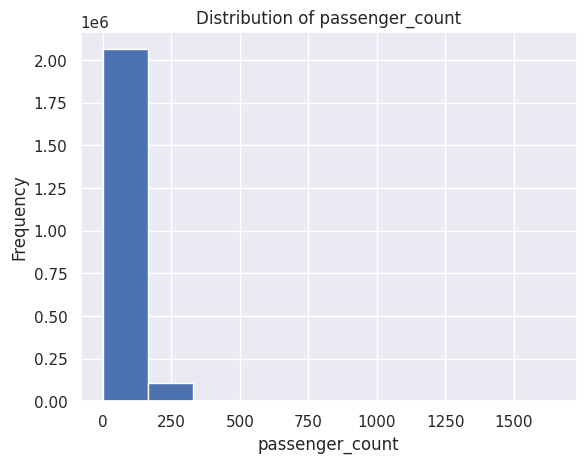

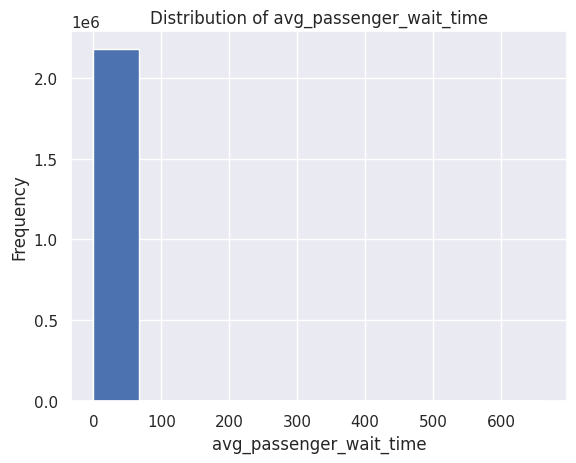

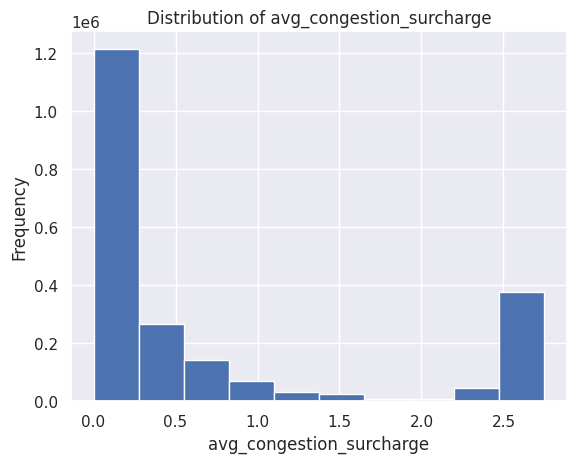

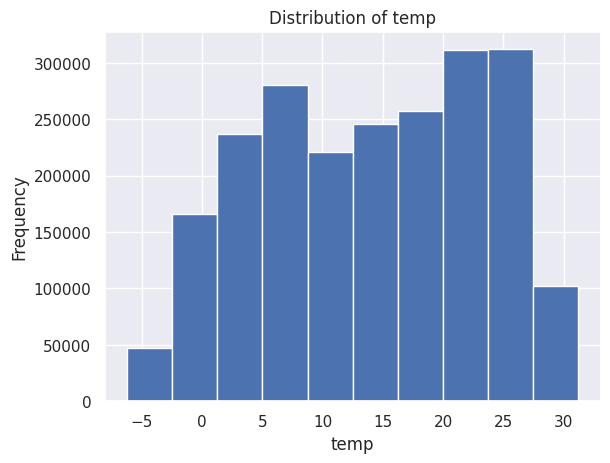

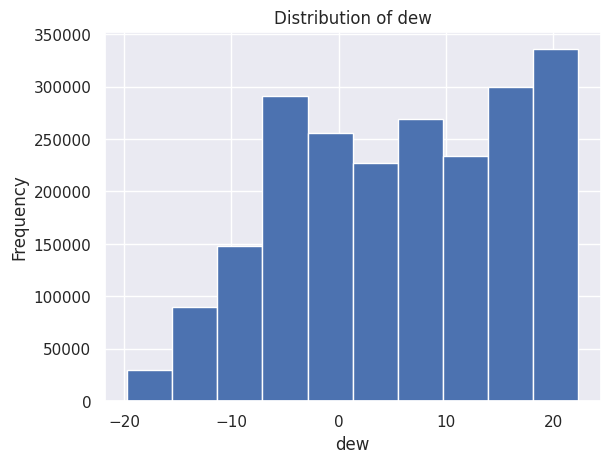

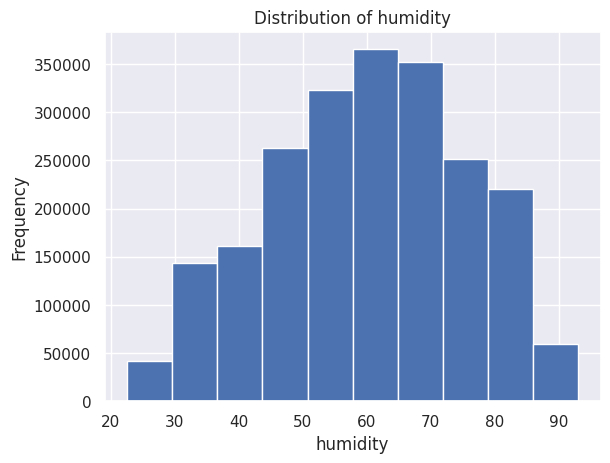

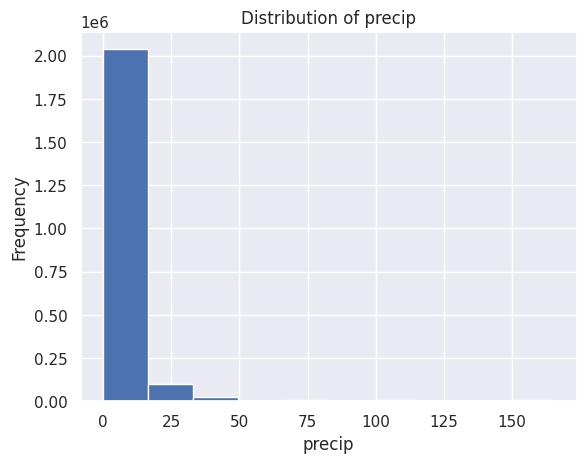

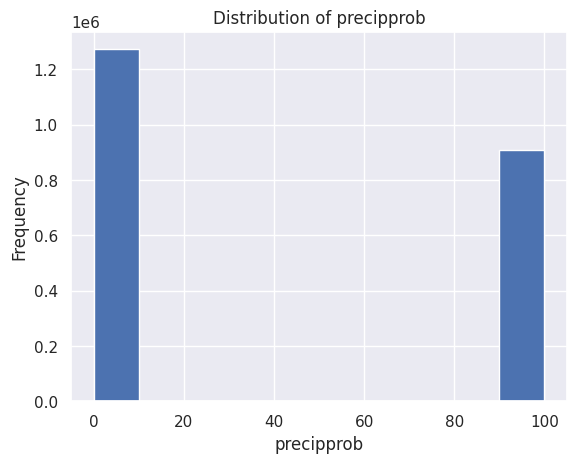

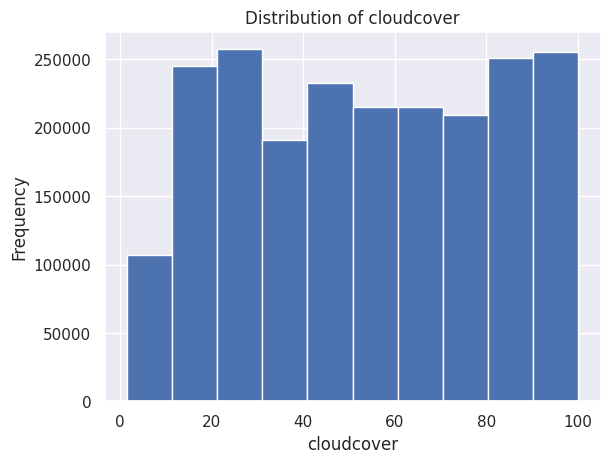

In [ ]:
sns.set()
vars = ['passenger_count','avg_passenger_wait_time','avg_congestion_surcharge','temp','dew','humidity','precip','precipprob','cloudcover']
for var in vars:
    plt.hist(data[var])
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {var}')
    plt.show()

Our passenger_count and avg_wait_time seem to be heavily skewed. I'll check the distribution of data without outliers and also will try to explore outliers.  

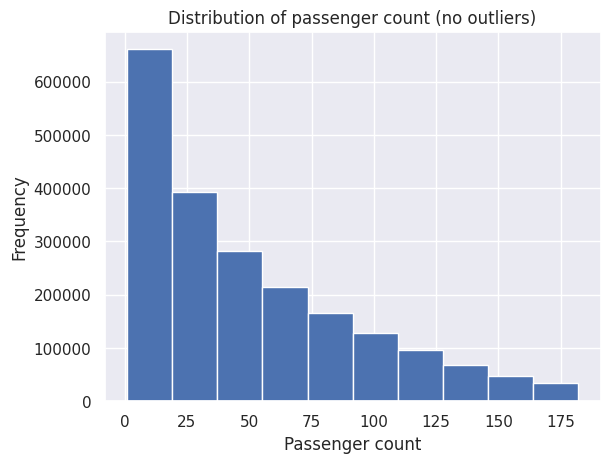

In [ ]:
# removing outliers from passenger_count
Q1_p = data['passenger_count'].quantile(0.25)
Q3_p = data['passenger_count'].quantile(0.75)
IQR_p = Q3_p - Q1_p
lower_bound_p = Q1_p - 1.5 * IQR_p
upper_bound_p = Q3_p + 1.5 * IQR_p

pc_no_outliers = data[(data['passenger_count'] >= lower_bound_p) & (data['passenger_count'] <= upper_bound_p)]
plt.hist(pc_no_outliers['passenger_count'])
plt.xlabel('Passenger count')
plt.ylabel('Frequency')
plt.title(f'Distribution of passenger count (no outliers)')
plt.show()

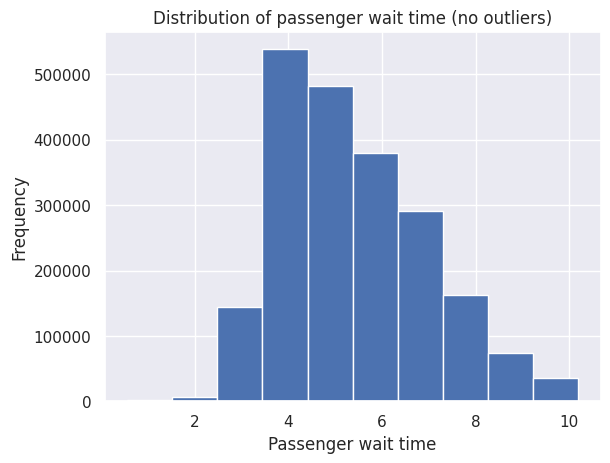

In [ ]:
# removing outliers from avg_wait_time
Q1_t = data['avg_passenger_wait_time'].quantile(0.25)
Q3_t = data['avg_passenger_wait_time'].quantile(0.75)
IQR_t = Q3_t - Q1_t
lower_bound_t = Q1_t - 1.5 * IQR_t
upper_bound_t = Q3_t + 1.5 * IQR_t

wt_no_outliers = data[(data['avg_passenger_wait_time'] >= lower_bound_t) & (data['avg_passenger_wait_time'] <= upper_bound_t)]
plt.hist(wt_no_outliers['avg_passenger_wait_time'])
plt.xlabel('Passenger wait time')
plt.ylabel('Frequency')
plt.title(f'Distribution of passenger wait time (no outliers)')
plt.show()

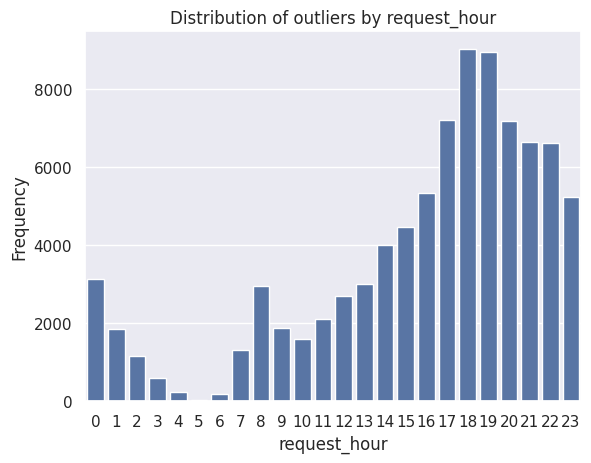

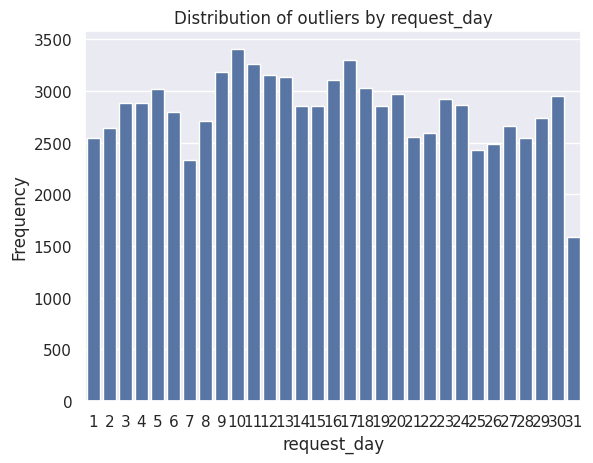

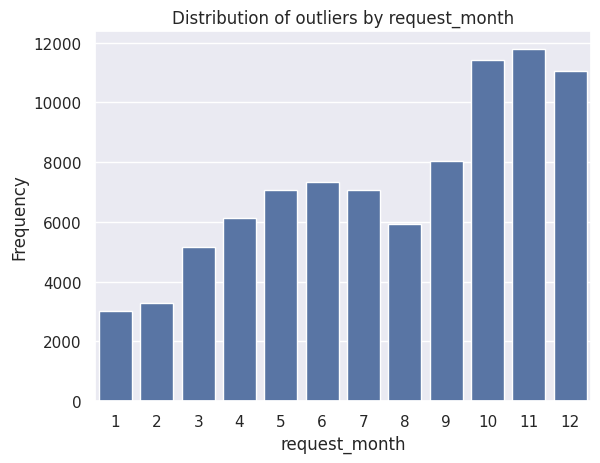

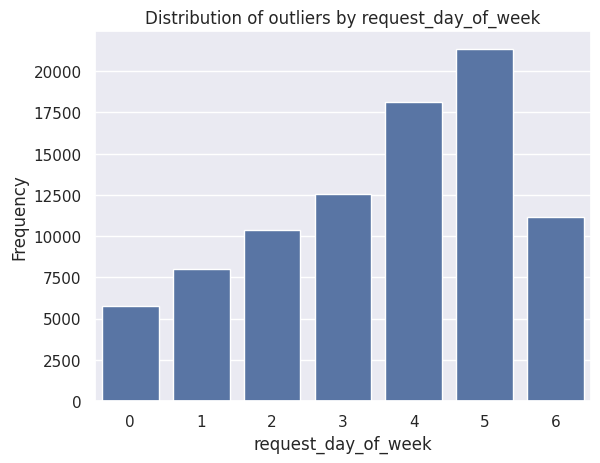

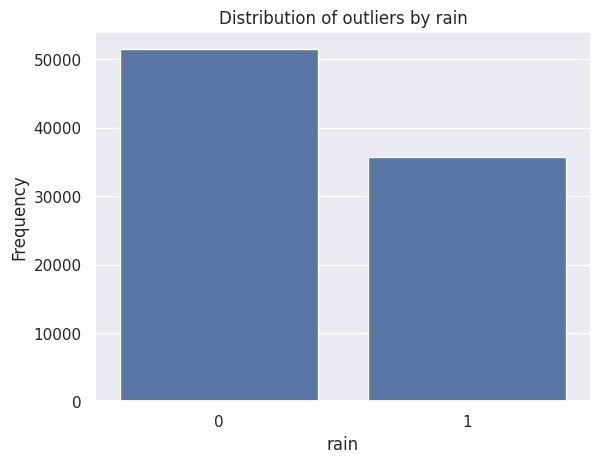

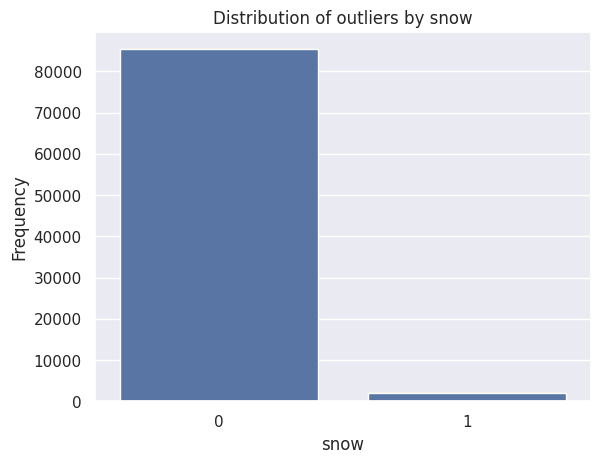

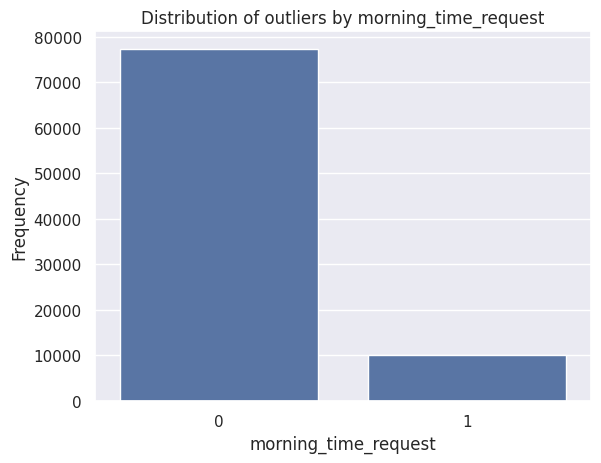

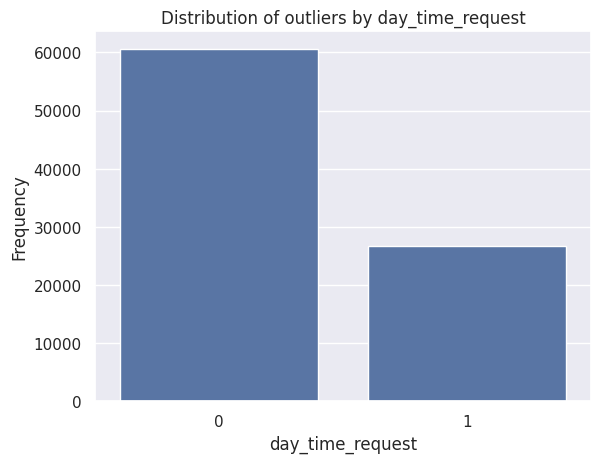

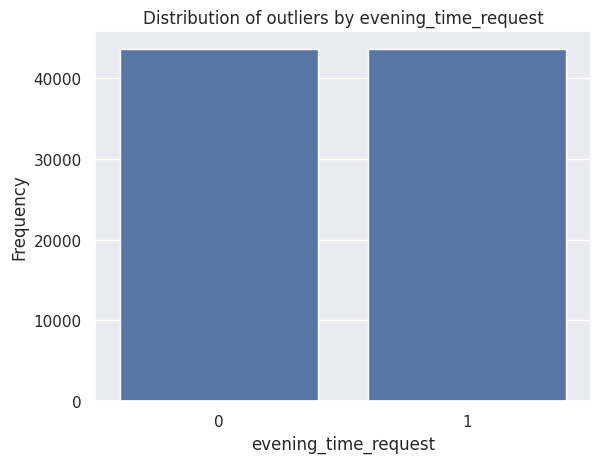

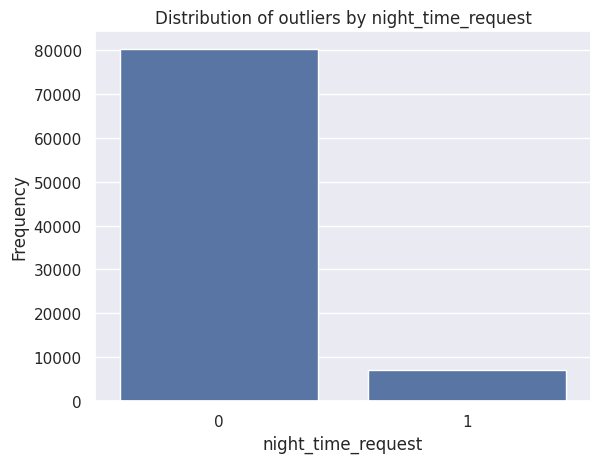

In [ ]:
# Exploring outliers for passenger count
pc_outliers = data[(data['passenger_count'] < lower_bound_p) | (data['passenger_count'] > upper_bound_p)]

dims = ['request_hour','request_day','request_month','request_day_of_week','rain','snow','morning_time_request','day_time_request','evening_time_request','night_time_request']
for dim in dims:
  sns.barplot(pc_outliers.groupby(dim).size())
  plt.xlabel(dim)
  plt.ylabel('Frequency')
  plt.title(f'Distribution of outliers by {dim}')
  plt.show()

Most of the outliers (surge) in passenger count happens around 6-7pm on Fridays and Saturdays, and in Oct, Nov, Dec. Perhaps, ppl are ordering uber rides when they go out.

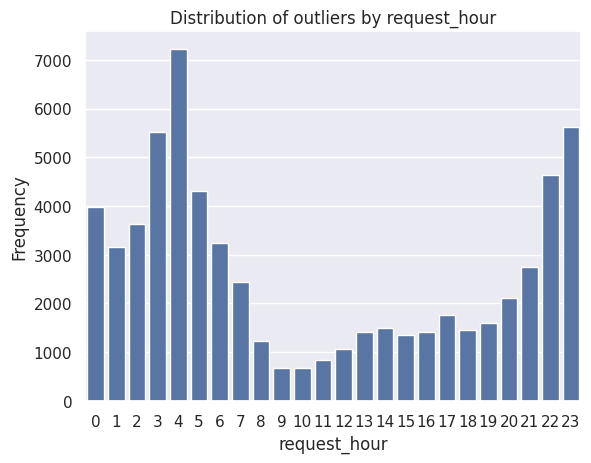

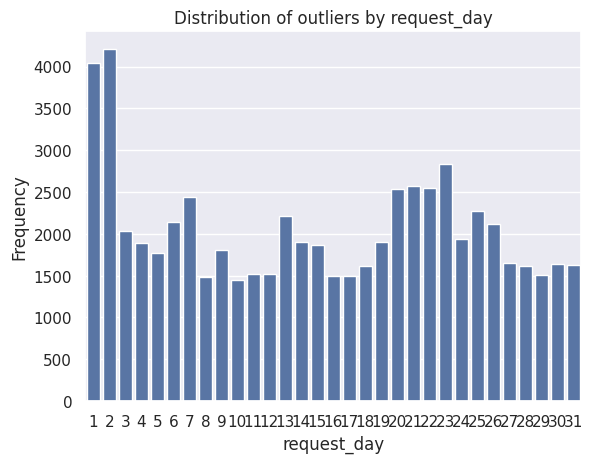

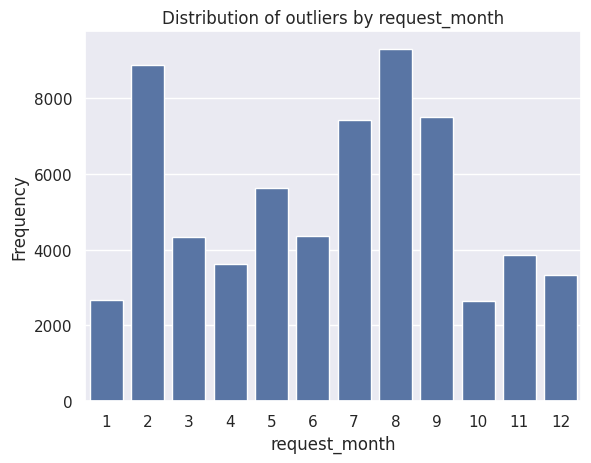

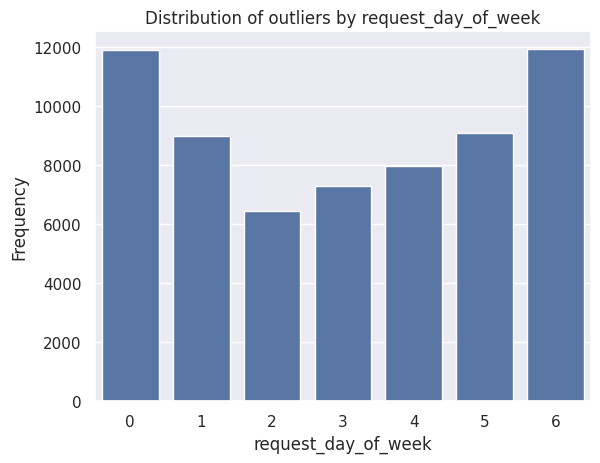

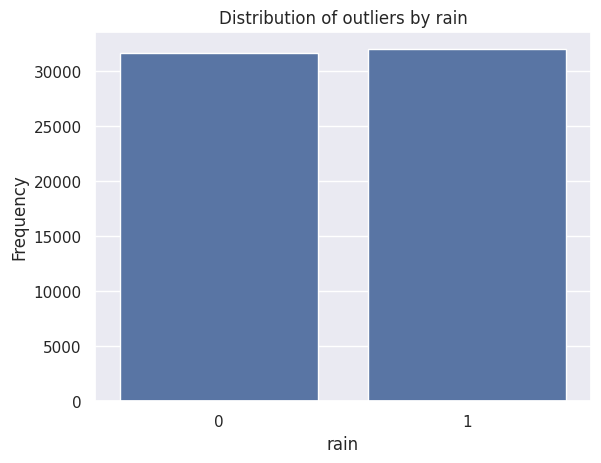

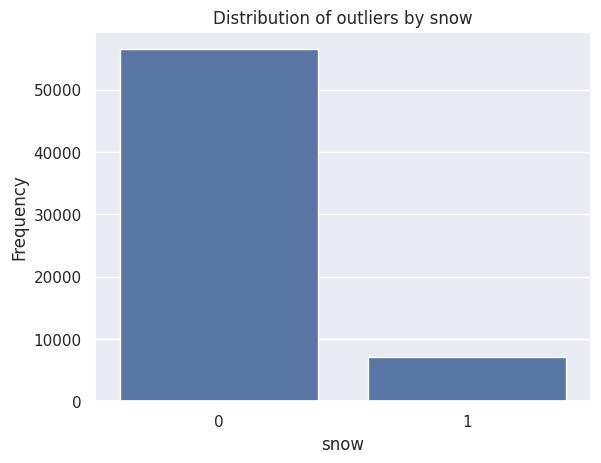

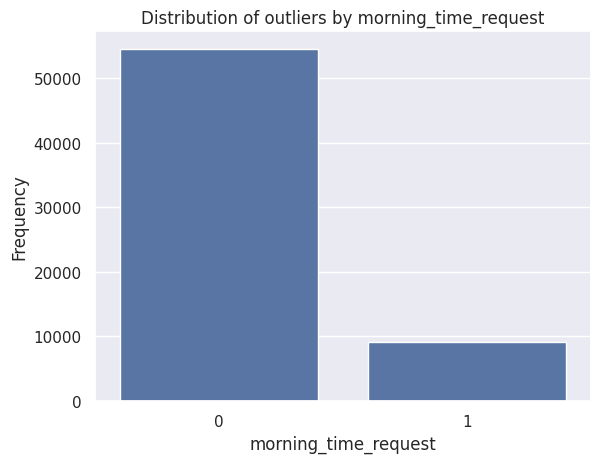

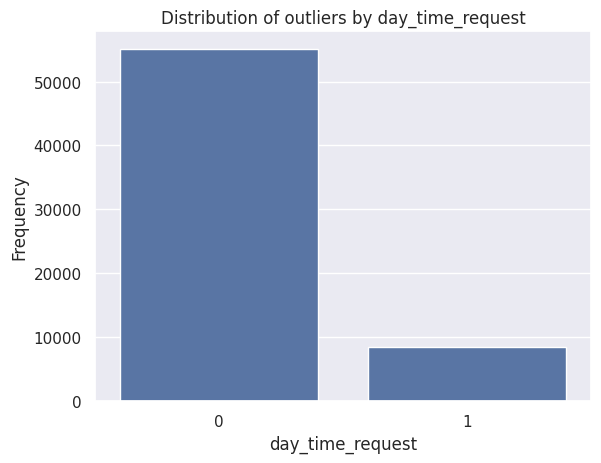

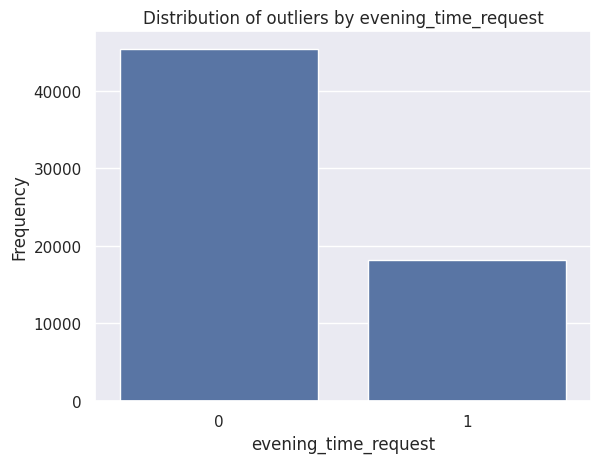

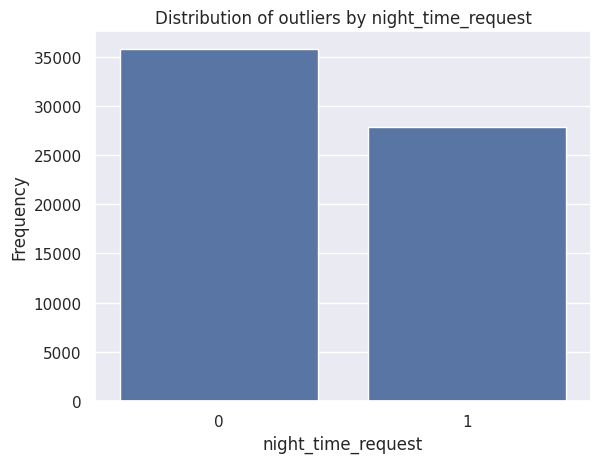

In [ ]:
# Exploring outliers for passenger wait time
wt_outliers = data[(data['avg_passenger_wait_time'] > upper_bound_t)]

dims = ['request_hour','request_day','request_month','request_day_of_week','rain','snow','morning_time_request','day_time_request','evening_time_request','night_time_request']
for dim in dims:
  sns.barplot(wt_outliers.groupby(dim).size())
  plt.xlabel(dim)
  plt.ylabel('Frequency')
  plt.title(f'Distribution of outliers by {dim}')
  plt.show()

The longest wait times are at night (between 10pm and 6am), on the 1st and 2nd day of the month, on Mondays and Sundays, when it rains, and during the months of Feb and Aug. Perhaps, wait times depend not only on increased demand (like when it rains), but also on decreased supply (for example, at night times).

### Categorical Features:
Checking counts / frequencies for pickup_zone, request_day_of_week, weather conditions (rain, snow), and time-related columns (morning_time_request, night_time_request, etc.)

<Axes: ylabel='Zone'>

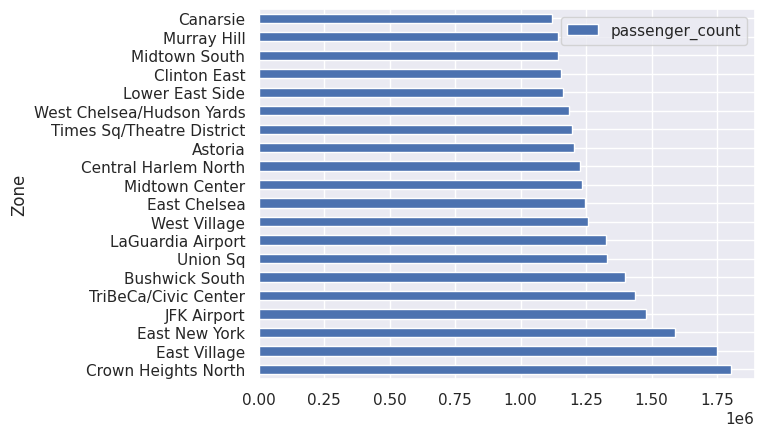

In [ ]:
demand[['Zone','passenger_count']].sort_values(by=['passenger_count'],ascending=False).head(20).plot(kind='barh', x='Zone', y='passenger_count')

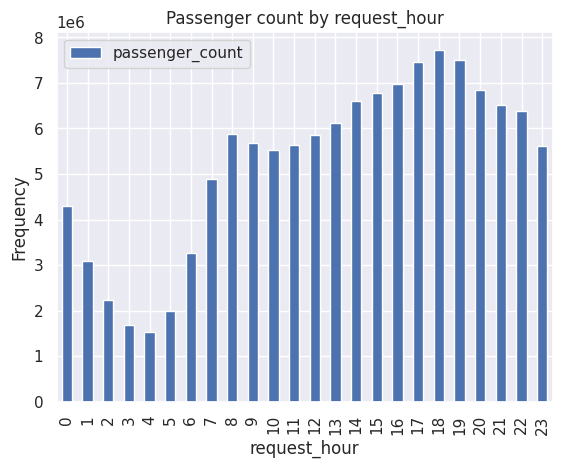

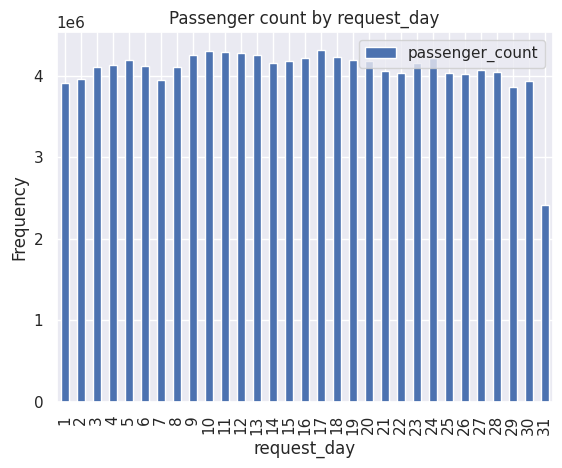

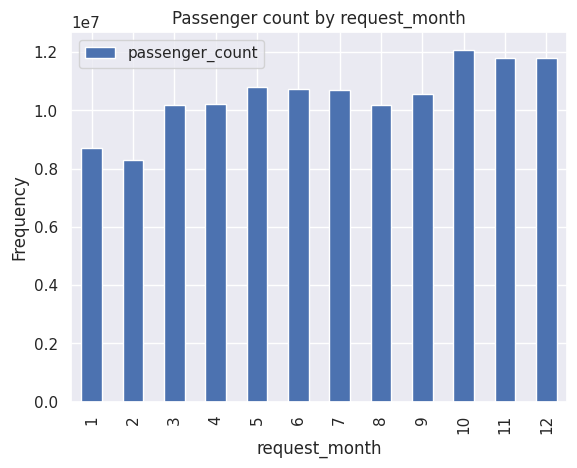

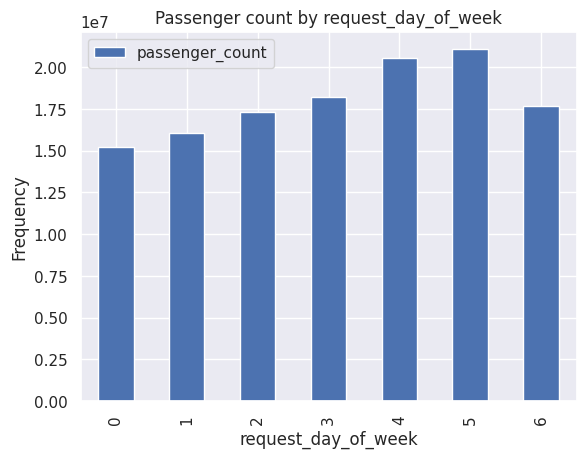

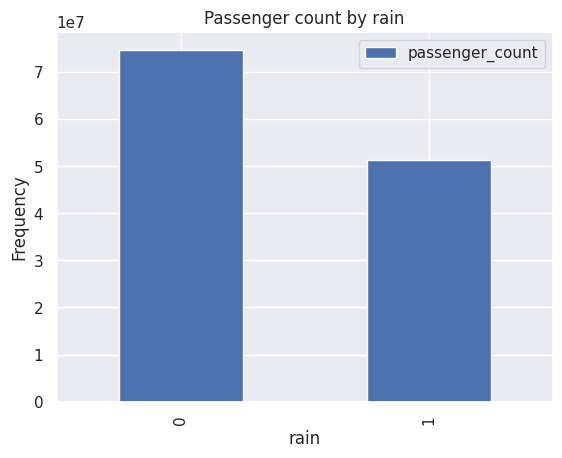

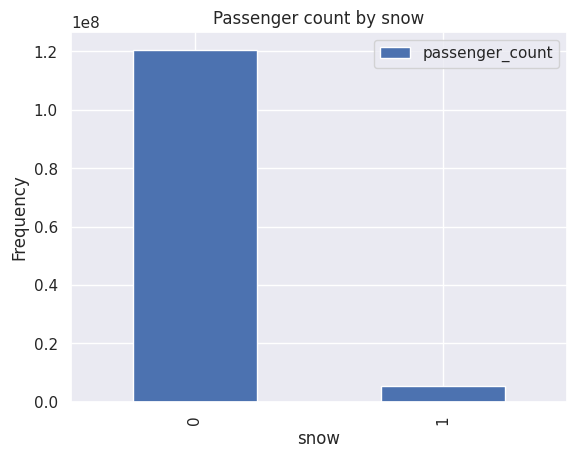

In [ ]:
dims = ['request_hour','request_day','request_month','request_day_of_week','rain','snow']

for dim in dims:
  data.groupby(dim).agg({'passenger_count':'sum'}).plot(kind='bar')
  plt.xlabel(dim)
  plt.ylabel('Frequency')
  plt.title(f'Passenger count by {dim}')
  plt.show()

<Axes: xlabel='time_of_day'>

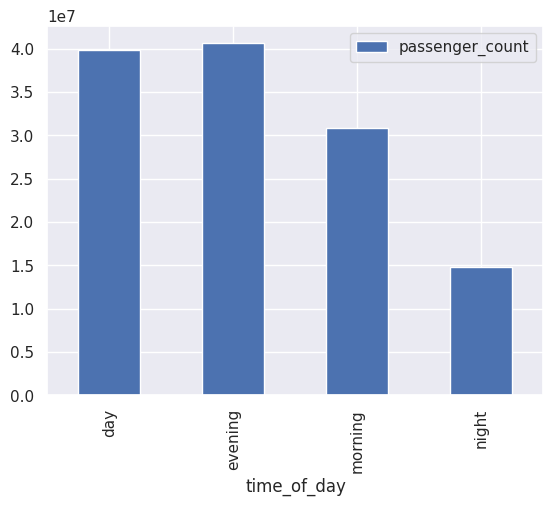

In [ ]:
conditions = [
    (data['morning_time_request'] == 1),
    (data['day_time_request'] == 1),
    (data['evening_time_request'] == 1),
    (data['night_time_request'] == 1)
]
choices = ['morning', 'day', 'evening', 'night']

data['time_of_day'] = np.select(conditions, choices, default=np.nan)
data.groupby('time_of_day').agg({'passenger_count':'sum'}).plot(kind='bar')

# Time Series Analysis
### Daily and Hourly Trends:


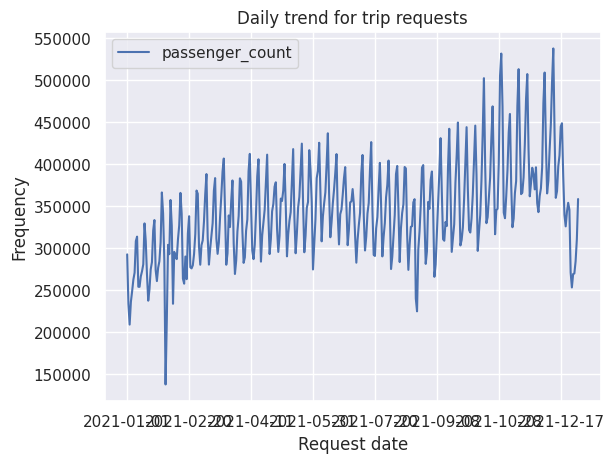

In [ ]:
# Checking daily trend to identify trends or seasonality.
data.groupby(['request_date']).agg({'passenger_count':'sum'}).plot(kind='line')
plt.xlabel('Request date')
plt.ylabel('Frequency')
plt.title('Daily trend for trip requests')
plt.show()

There's a clear seasonality pattern with spikes on the weekends, an upward trend in Nov-Dec and a drop in the end of the year.

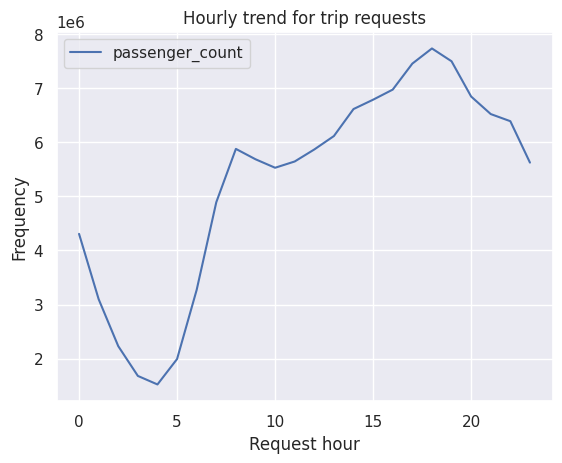

In [ ]:
# Checking hourly trend to identify peak and off-peak hours.
data.groupby(['request_hour']).agg({'passenger_count':'sum'}).plot(kind='line')
plt.xlabel('Request hour')
plt.ylabel('Frequency')
plt.title('Hourly trend for trip requests')
plt.show()

### Monthly and Day of Week Patterns:

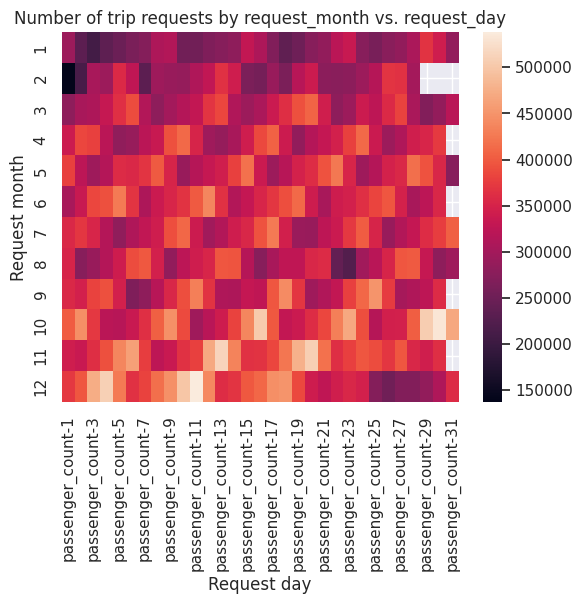

In [ ]:
# Using heatmap to visualize the number of trip requests by request_month vs. request_day to detect trends on specific days.
sns.heatmap(data.groupby(['request_month','request_day']).agg({'passenger_count':'sum'}).unstack())
plt.xlabel('Request day')
plt.ylabel('Request month')
plt.title('Number of trip requests by request_month vs. request_day')
plt.show()

There's a pattern in data - the highest number of requests happen on the weekends (Fri-Sun) with weekends in Oct-Dec (Oct 16, Oct 30, Nov 13, Nov 20, Dec 4 & Dec 11). Perhaps, due to end of the year being a festive season with Halloween, Thanksgiving and Christmas celebrations.
The lowest number of request are in the first week of Jan, Feb 1-2, Aug 12-13 and last week of Dec.


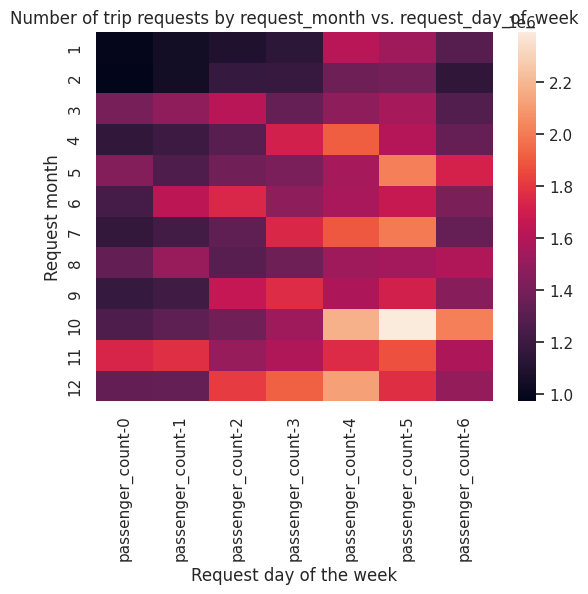

In [ ]:
# Using heatmap to visualize the number of trip requests by request_month vs. request_day_of_week.
sns.heatmap(data.groupby(['request_month','request_day_of_week']).agg({'passenger_count':'sum'}).unstack())
plt.xlabel('Request day of the week')
plt.ylabel('Request month')
plt.title('Number of trip requests by request_month vs. request_day_of_week')
plt.show()

Weekdays in Jan and Feb have the least number of requests. Saturdays and Sundays in Oct have the highest number of requests.

# Geospatial Analysis
Visualizing taxi pickup zones using a geographic map to identify zones with high demand.

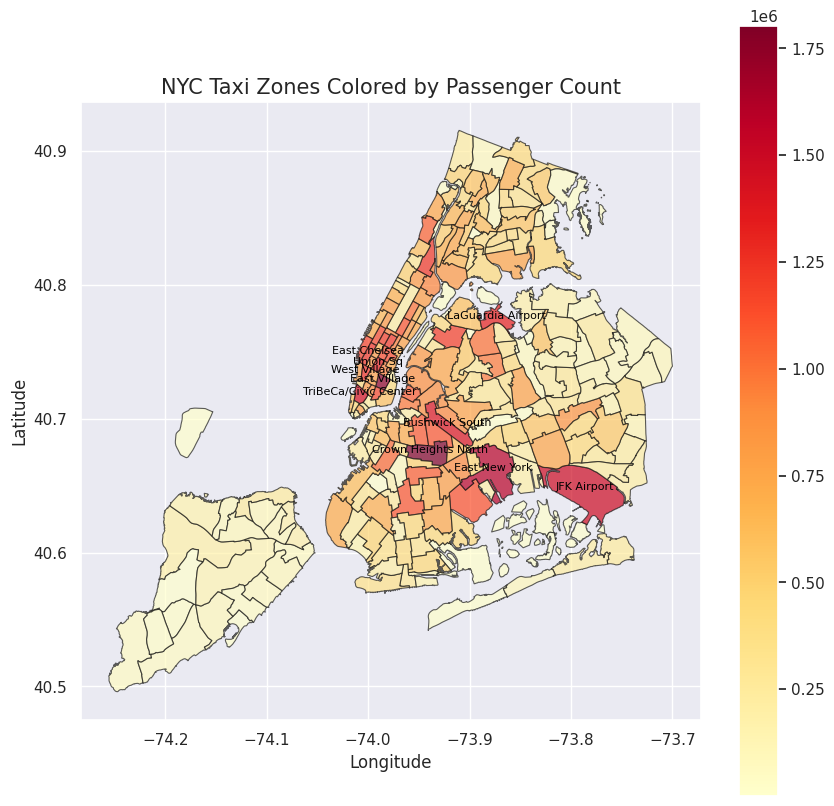

In [ ]:
demand = gpd.GeoDataFrame(demand, geometry='geometry')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

demand.plot(column='passenger_count',
            cmap='YlOrRd',
            linewidth=0.8,
            ax=ax,
            edgecolor='k',
            legend=True,
            alpha=0.7)

top_zones = demand.nlargest(10, 'passenger_count')

for idx, row in top_zones.iterrows():
    centroid = row['geometry'].centroid
    plt.text(x=centroid.x,
             y=centroid.y,
             s=row['Zone'],  # Adding label with the zone name
             fontsize=8,
             color='black',
             ha='center')

plt.title('NYC Taxi Zones Colored by Passenger Count', fontsize=15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Step 3: Show the plot
plt.show()


# Correlation Analysis
### Exploring correlation between weather and trip requests

In [6]:
# Subsetting data to one zone only (Tribeca / Civic Center), one day of week (Saturday) and day time - to reduce noise when analyzing impact of weather
data_subs = data[(data['PULocationID'] == 231)&(data['request_day_of_week']==5)&(data['day_time_request']==1)]

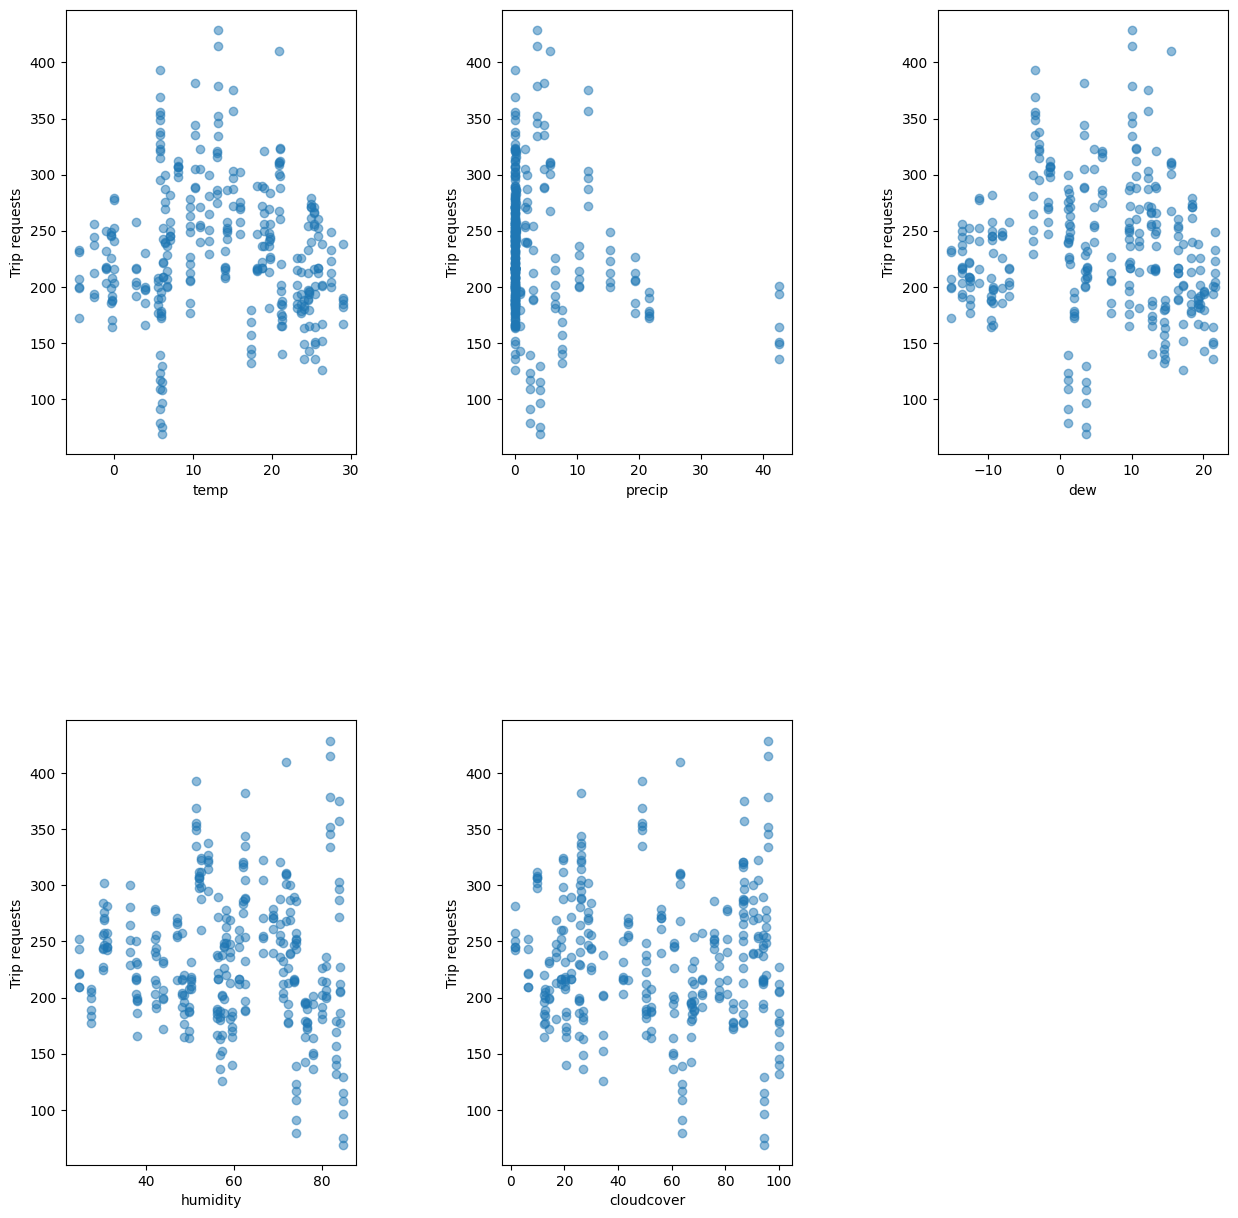

In [7]:
# Using scatter plots to explore relationships between temp, precip, avg_passenger_wait_time, etc., against the number of trip requests
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'passenger_count', data=data_subs, alpha=0.5)
        ax.set(xlabel=col, ylabel='Trip requests')
    nsubplots = nrow * ncol
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

features = ['temp','precip','dew','humidity','cloudcover']
scatterplots(features, ncol=3, figsize=(15, 15))

<Axes: >

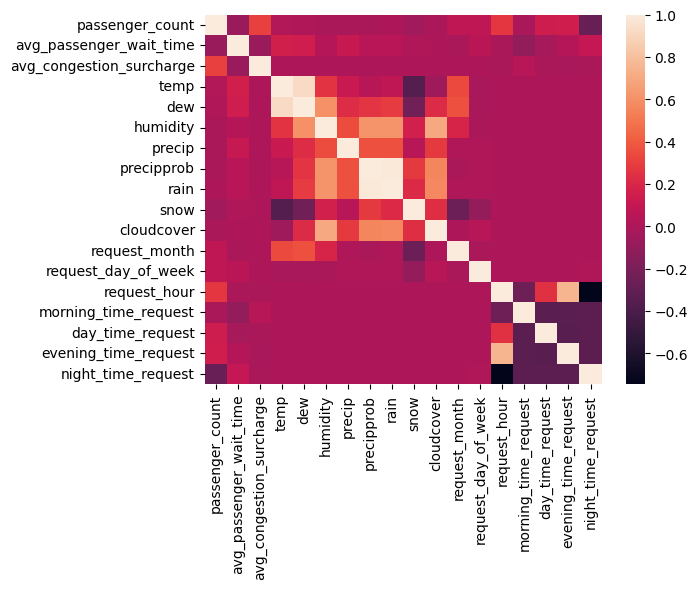

In [ ]:
# Using a correlation matrix and a heatmap to identify relationships between numerical features
numeric_features = ['passenger_count','avg_passenger_wait_time','avg_congestion_surcharge','temp','dew','humidity','precip','precipprob','rain','snow','cloudcover','request_month','request_day_of_week','request_hour','morning_time_request','day_time_request','evening_time_request','night_time_request']
sns.heatmap(data[numeric_features].corr())

In [ ]:
# Checking pearson correlation between passenger count and each numeric feature
for feature in numeric_features:
  pearson_corr, p_value = stats.pearsonr(data[feature], data['passenger_count'])
  print(f"Pearson correlation between {feature} and passenger_count: {pearson_corr}, p-value: {p_value}")

Pearson correlation between passenger_count and passenger_count: 0.9999999999998657, p-value: 0.0
Pearson correlation between avg_passenger_wait_time and passenger_count: -0.07420200078734754, p-value: 0.0
Pearson correlation between avg_congestion_surcharge and passenger_count: 0.31048787880164763, p-value: 0.0
Pearson correlation between temp and passenger_count: 0.024123361291734688, p-value: 7.017571972593336e-278
Pearson correlation between dew and passenger_count: 0.017111347594162028, p-value: 7.954356216817948e-141
Pearson correlation between humidity and passenger_count: -0.009670238578485082, p-value: 3.0501009048447326e-46
Pearson correlation between precip and passenger_count: -0.009296723868847953, p-value: 7.153742807798934e-43
Pearson correlation between precipprob and passenger_count: -0.005001283284514772, p-value: 1.5403496155545015e-13
Pearson correlation between rain and passenger_count: -0.0020061372975217, p-value: 0.003059078870528237
Pearson correlation between 

Features that have the biggest significant impact on trip requests:
* request hour
* request month
* request day of week
* snow

Note: average passenger wait time and average congestion surcharge also have significant and high correlation with passenger count, but these are not features we can use for predictions (they are rather a result of high number of ride requests).


#Exploring interactions between features


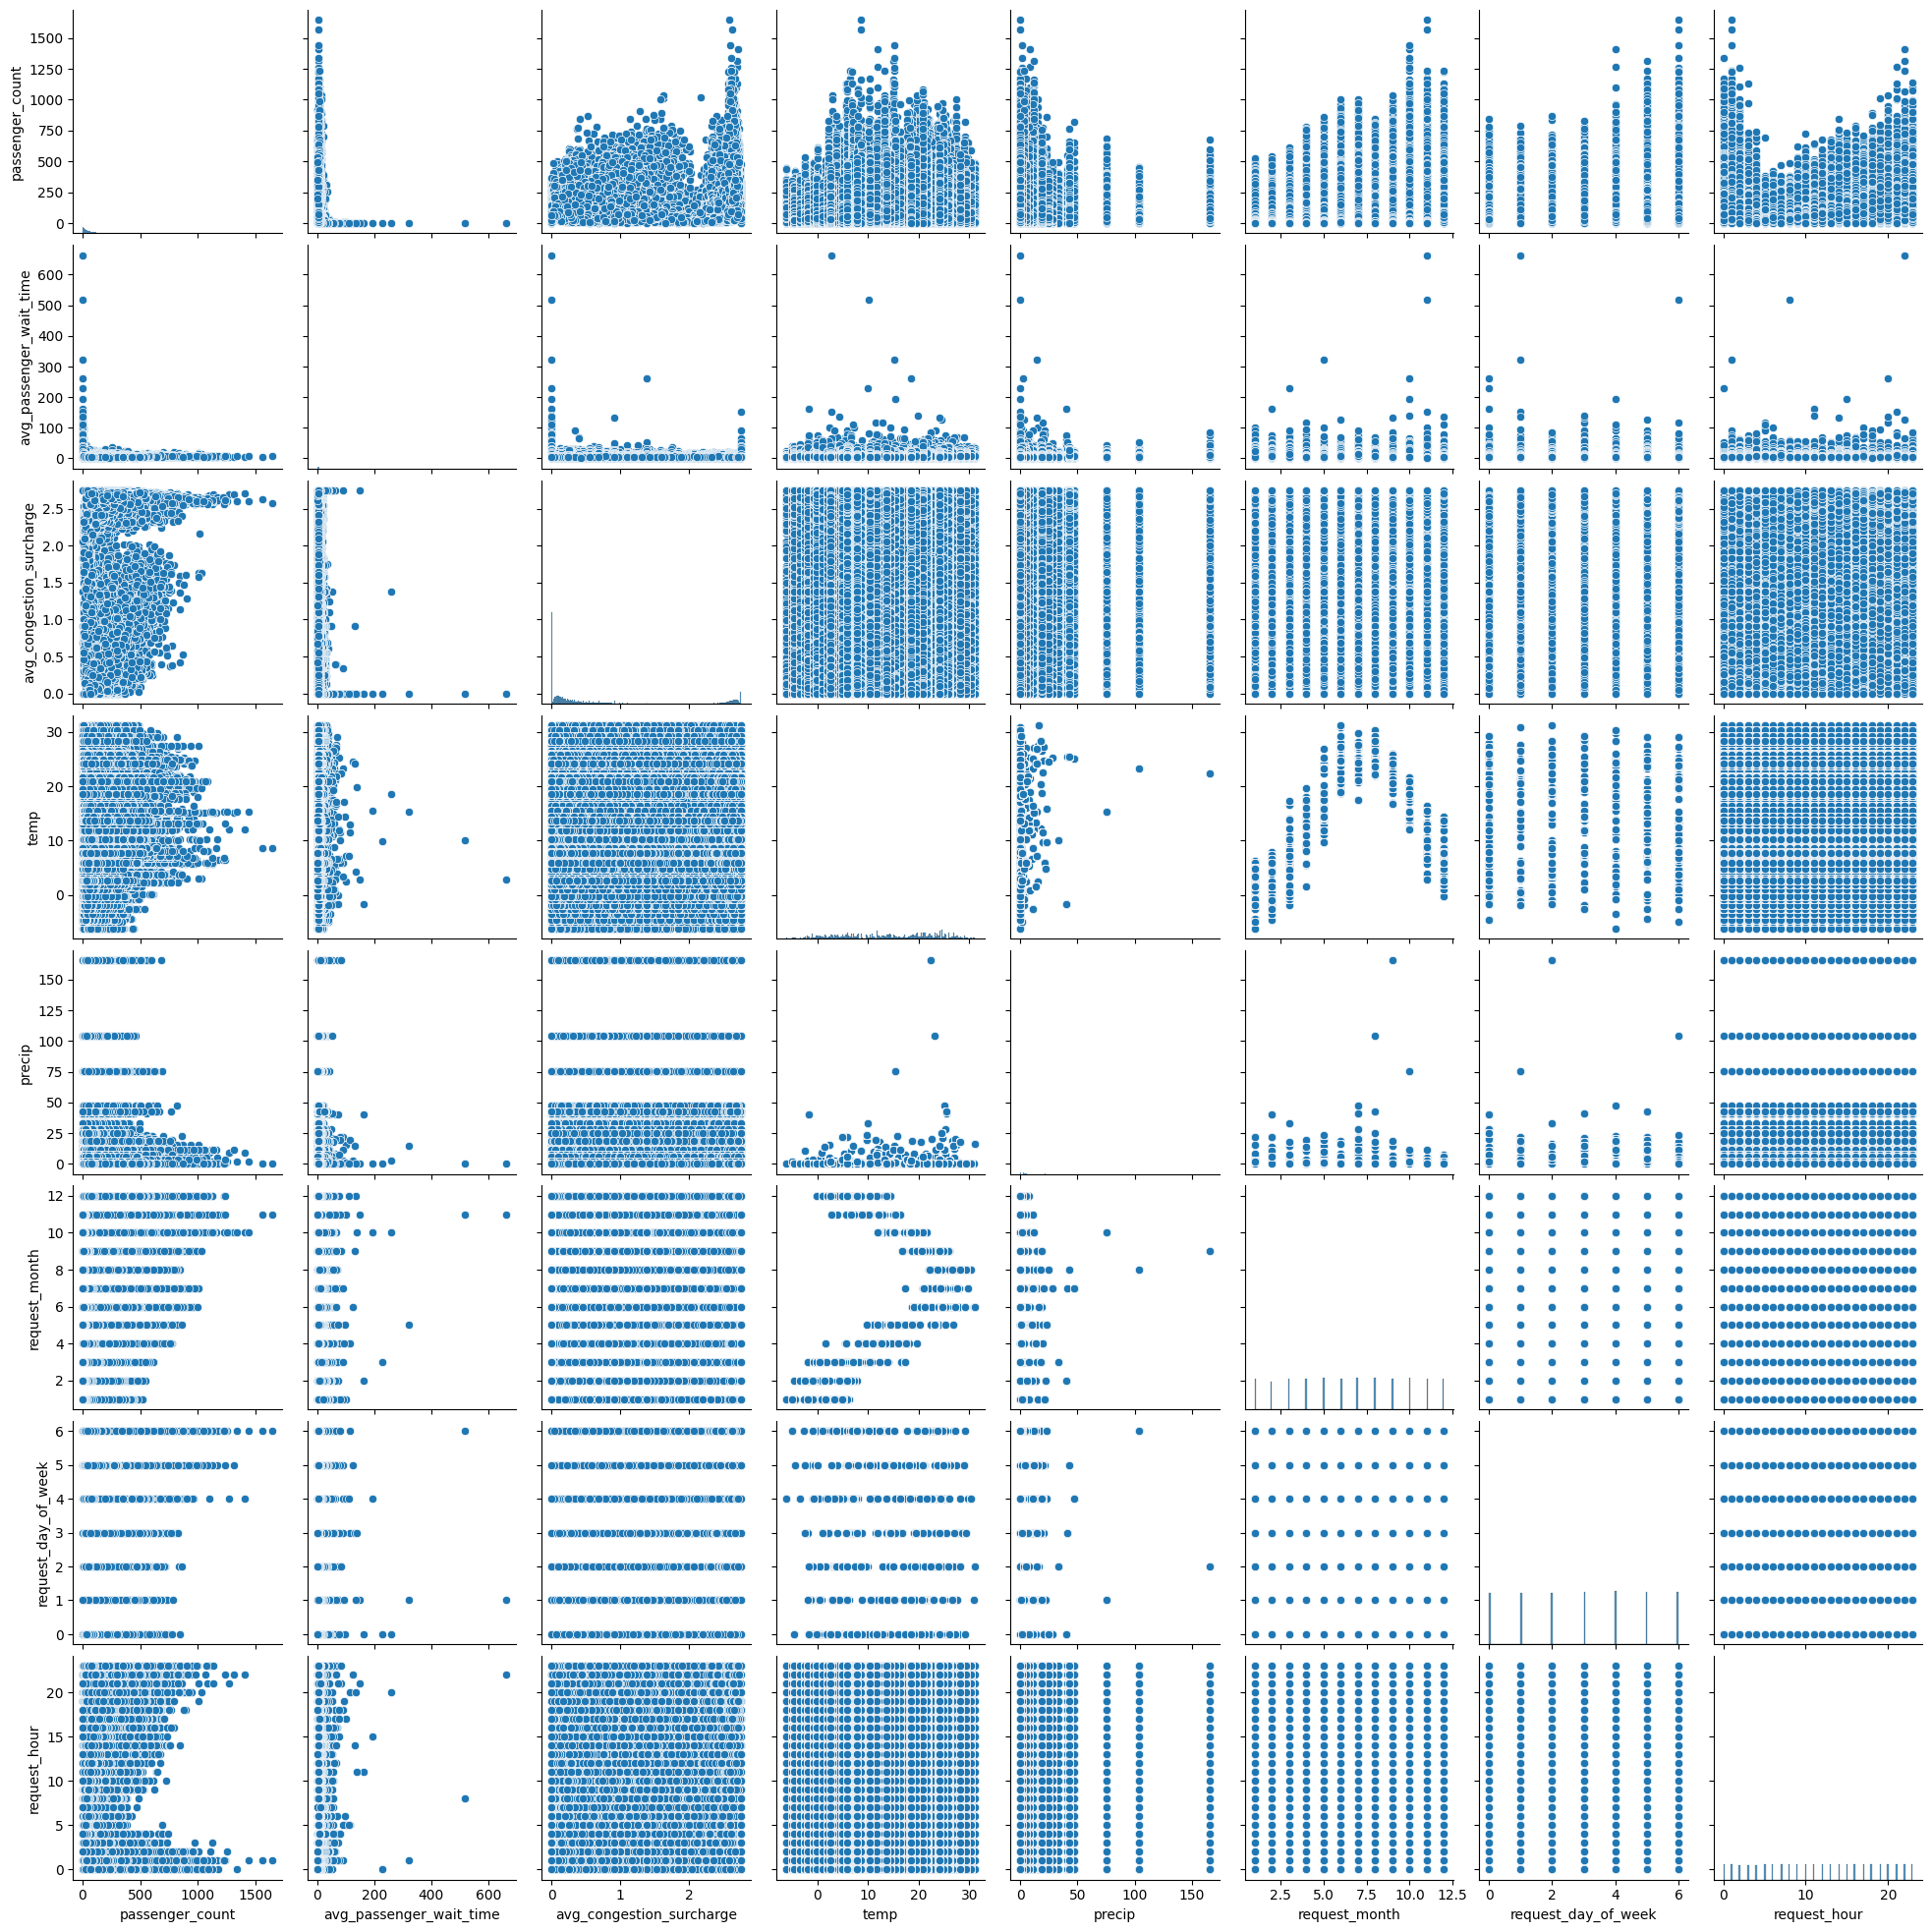

In [9]:
numeric_features = numeric_features = ['passenger_count','avg_passenger_wait_time','avg_congestion_surcharge','temp','precip','request_month','request_day_of_week','request_hour']
sns.pairplot(data[numeric_features])